# MCMC with additional priors

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc

p21mc.__version__

'1.0.0dev3'

In this tutorial, we introduce priors in ``21CMMC`` pipeline. Generally, MCMC pipelines have only flat-prior definitions. However, some previous posterior results wrapped in an analytical function, could potentially be used as an additional prior. Here we explain how to make use of it in ``21CMMC``.

## Code structure

We are starting from an observation that any prior is just a multiplicative function to the likelihood, as long as data used to constrain our prior knowledge is decoupled from current data on which the likelihood is built. With such assumption, we can add priors to our ``LikelihoodComputationChain`` just as any other likelihood. Both mathematically and in code, there's no difference.

The main prior class ``PriorBase`` is based on (inherits from) ``LikelihoodBase``, providing all same functionality. To use it, one needs to simply concatenate it to all other likelihoods computed in the chain.

Main functionality is provided with ``PriorFunction`` class, a simple wrapper which takes: ``argument_values`` - names of arguments which are varied in a particular MCMC run, and a prior function ``f``.

## Running MCMC
Let's build a simple example of a prior function with it!

In [2]:
from scipy.stats import multivariate_normal
mu = np.array([30., 4.7])
cov = 0.1 ** 2 * np.array([[1., 0.9], [0.9, 1.]])
rv = multivariate_normal(mu, cov)
def f(x):
    return rv.logpdf(x)
priors = [p21mc.PriorFunction(arg_names = ["HII_EFF_FACTOR", "ION_Tvir_MIN"], f = f)] # add potentially more priors
likelihoods = [] # add likelihoods
cores = [] # add cores

Now we have all we need to start running the MCMC. The most important part of the call to ``run_mcmc`` is the specification of ``params``, which specifies which are the parameters *to be fit*. This is passed as a dictionary, where the keys are the parameter names, and *must* come from either ``cosmo_params`` or ``astro_params``, and be of ``float`` type. The values of the dictionary are length-4 lists: ``(guess, min, max, width)``. The first specifies where the best guess of the true value lies, and the initial walkers will be chosen around here. The ``min/max`` arguments provide upper and lower limits on the parameter, outside of which the likelihood will be ``-infinity``. The ``width`` affects the initial distribution of walkers around the best-guess (it does *not* influence any kind of "prior"). 

Now we start the MCMC. Taking a close look at ``params`` dictionary, which consists of ``(guess, min, max, width)`` lists for every parameter, ``min`` and ``max`` values represent an initial "flat prior". All others will be sent with ``priors`` list. Parameters defined in ``params`` list are the relevant ones for ``arg_names`` in the ``PriorFunction`` definition.

In [3]:
model_name = "SimpleTest"

chain = mcmc.run_mcmc(
    cores,                   # List of cores.
    priors + likelihoods,    # List of priors and likelihoods.
    datadir='data',          # Directory for all outputs.
    model_name=model_name,   # Filename of main chain output.
    params=dict(             # Parameter dict.
        HII_EFF_FACTOR = [30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN = [4.7, 4, 6, 0.1],
    ), 
    walkersRatio=4,          # The number of walkers will be walkersRatio*nparams.
    burninIterations=0,      # Number of iterations to save as burnin. Recommended to leave as zero.
    sampleIterations=500,    # Number of iterations to sample, per walker.
    threadCount=4,           # Number of processes to use in MCMC (best as a factor of walkersRatio).
    continue_sampling=False  # Whether to contine sampling from previous run *up to* sampleIterations.
)

## Analysis

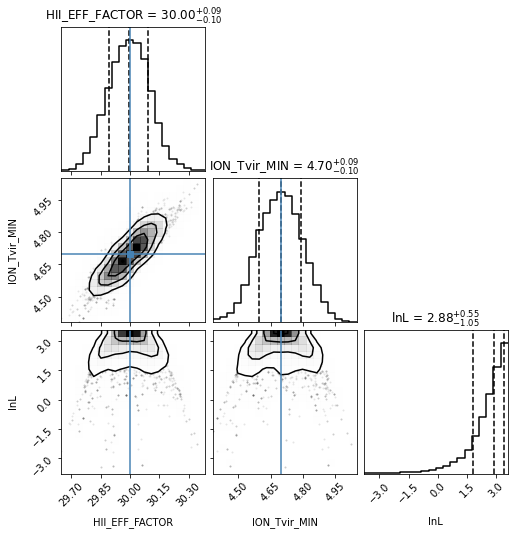

In [9]:
analyse.corner_plot(chain.samples, start_iter = 50);

## KDE prior
Except basic functionality, class ``PriorGaussianKDE`` implements a gaussian KDE estimation for a set of points. Such functionality can be useful when one would like to wrap a previous MCMC chain as a prior for the new run.

In [17]:
data = chain.samples.get_chain(discard=50, thin=1)
data = data.reshape(-1, 2)
data.shape

((3600, 2), numpy.ndarray)

In [19]:
prior = p21mc.PriorGaussianKDE(
    data,                                # data to fit
    ["HII_EFF_FACTOR", "ION_Tvir_MIN"],  # parameters
    bandwidth = None,                    # gaussian bandwidth, if unset, calculates optimal bandwidth
    whiten = True,                       
    whitening_algorithm = "ZCA",
)

In [20]:
model_name = "SimpleTest"

chain = mcmc.run_mcmc(
    [], prior,
    datadir='data',          # Directory for all outputs.
    model_name=model_name,   # Filename of main chain output.
    params=dict(             # Parameter dict.
        HII_EFF_FACTOR = [30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN = [4.7, 4, 6, 0.1],
    ), 
    walkersRatio=4,          # The number of walkers will be walkersRatio*nparams.
    burninIterations=0,      # Number of iterations to save as burnin. Recommended to leave as zero.
    sampleIterations=500,    # Number of iterations to sample, per walker.
    threadCount=4,           # Number of processes to use in MCMC (best as a factor of walkersRatio).
    continue_sampling=False  # Whether to contine sampling from previous run *up to* sampleIterations.
)

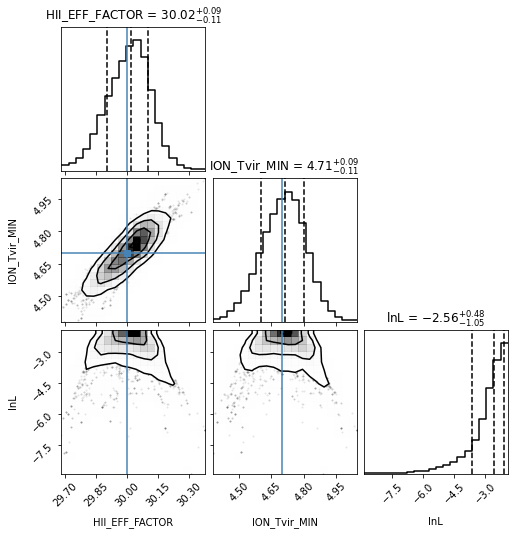

In [21]:
analyse.corner_plot(chain.samples, start_iter = 50);